In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import seaborn as sns

toPounds = 2.20462
toKgs = 1/toPounds

# import workout data
workout_history = pd.read_csv('data/strong.csv')

# data cleansing
# remove "Warmup sets" (first 2 sets)
workout_history.drop(workout_history[workout_history['Set Order'] < 3].index, inplace = True)
# shift "Working set" order (up 2 sets)
workout_history["Set Order"] = workout_history["Set Order"] - 2
# remove last set
workout_history.drop(workout_history[workout_history['Set Order'] >= 6].index, inplace = True)

In [2]:
print(workout_history)

                     Date Workout Name Duration  \
2     2022-10-16 00:16:36    Shoulders    28min   
3     2022-10-16 00:16:36    Shoulders    28min   
4     2022-10-16 00:16:36    Shoulders    28min   
5     2022-10-16 00:16:36    Shoulders    28min   
6     2022-10-16 00:16:36    Shoulders    28min   
...                   ...          ...      ...   
1148  2023-07-21 00:08:04    Shoulders    41min   
1149  2023-07-21 00:08:04    Shoulders    41min   
1150  2023-07-21 00:08:04    Shoulders    41min   
1151  2023-07-21 00:08:04    Shoulders    41min   
1152  2023-07-21 00:08:04    Shoulders    41min   

                        Exercise Name  Set Order  Weight  Reps  Distance  \
2     Seated Overhead Press (Barbell)          1    50.0    10         0   
3     Seated Overhead Press (Barbell)          2    50.0    10         0   
4     Seated Overhead Press (Barbell)          3    50.0     8         0   
5     Seated Overhead Press (Barbell)          4    45.0     8         0   
6     S

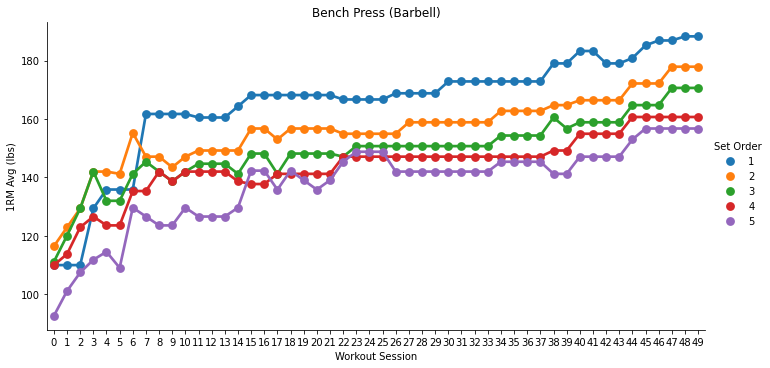

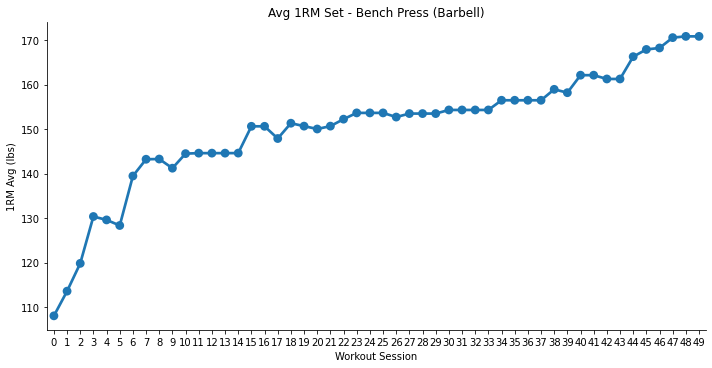

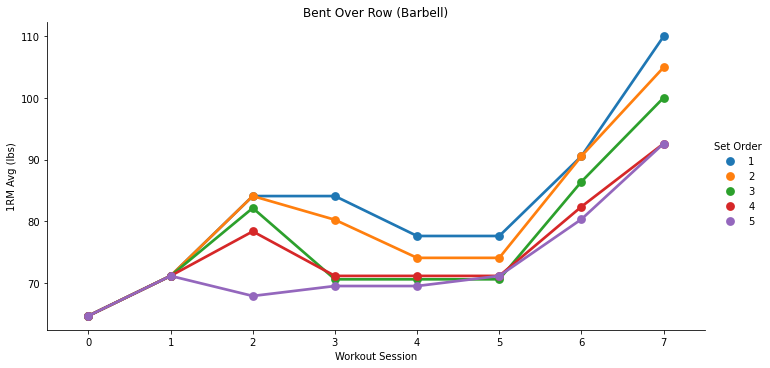

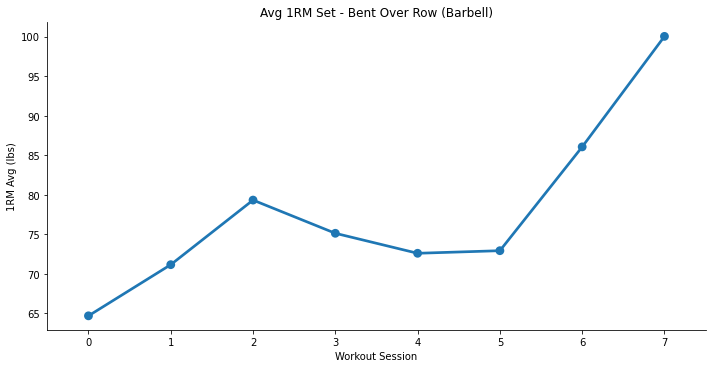

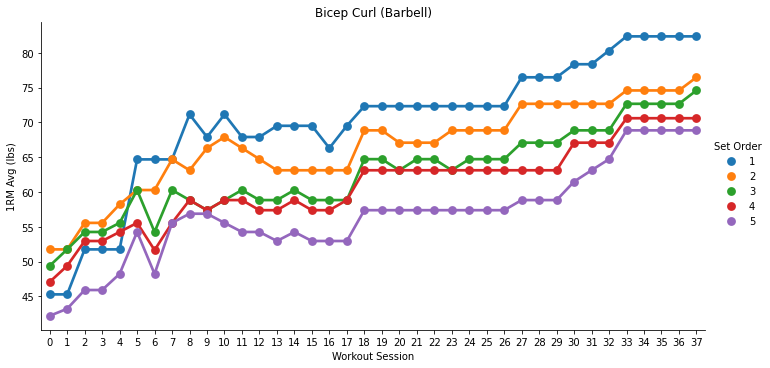

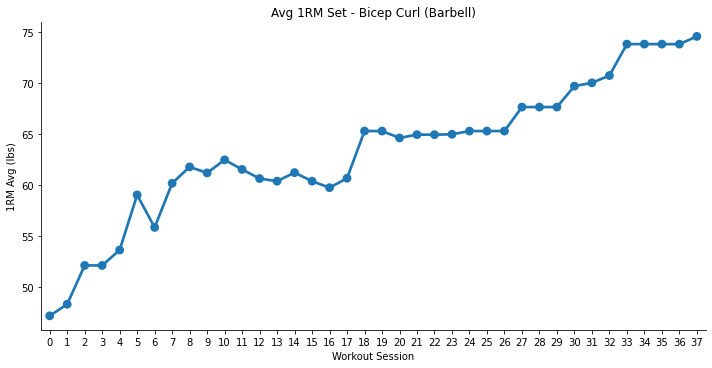

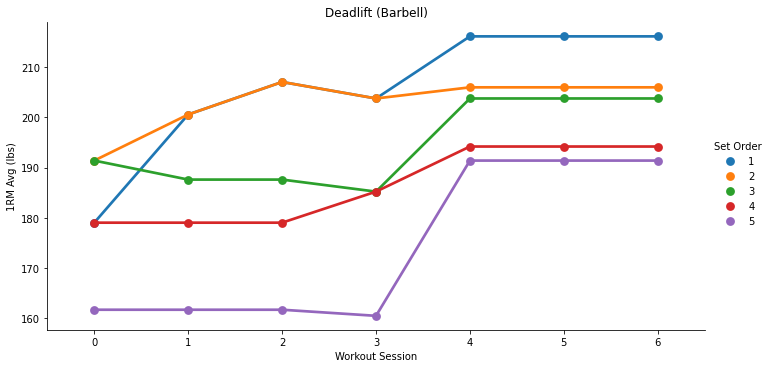

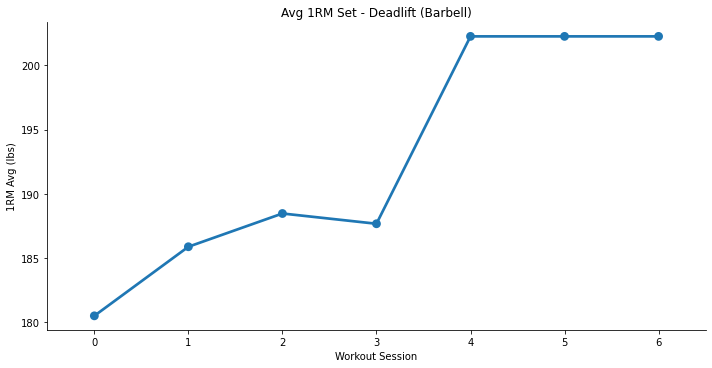

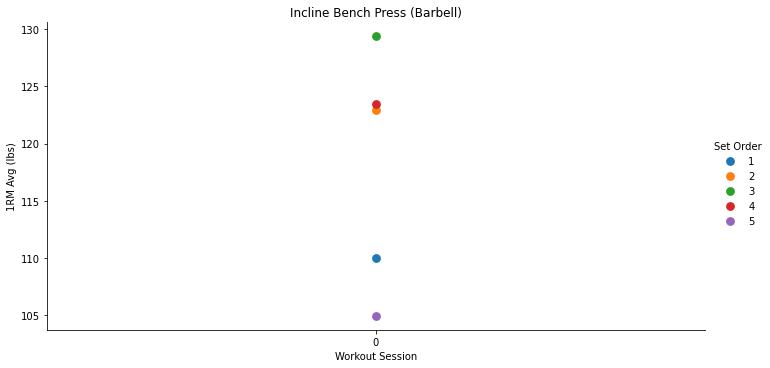

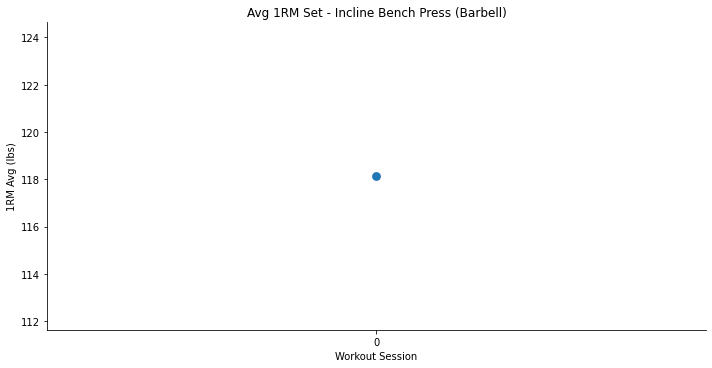

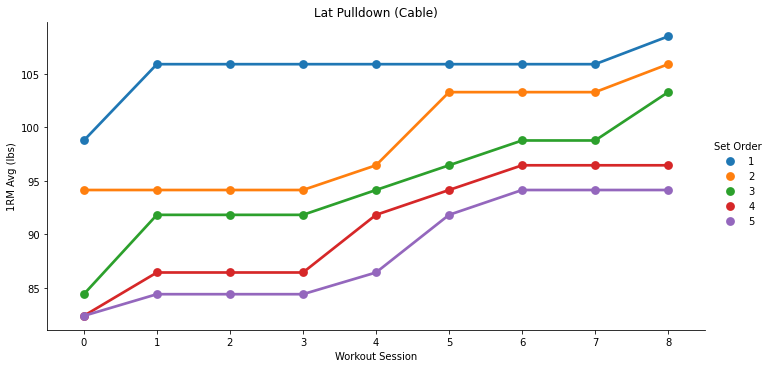

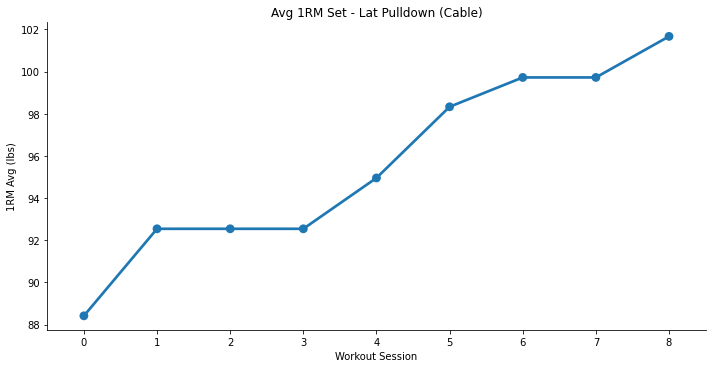

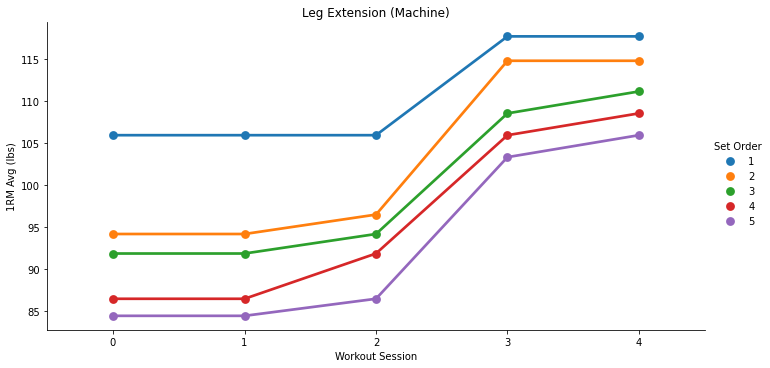

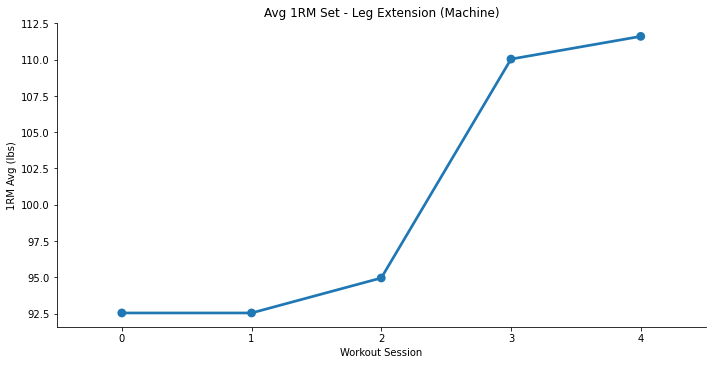

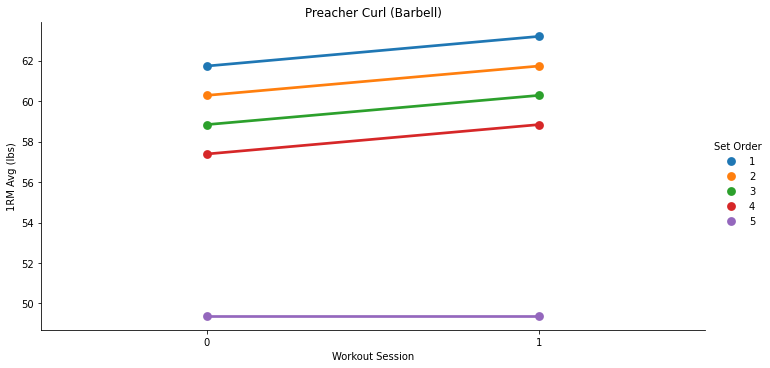

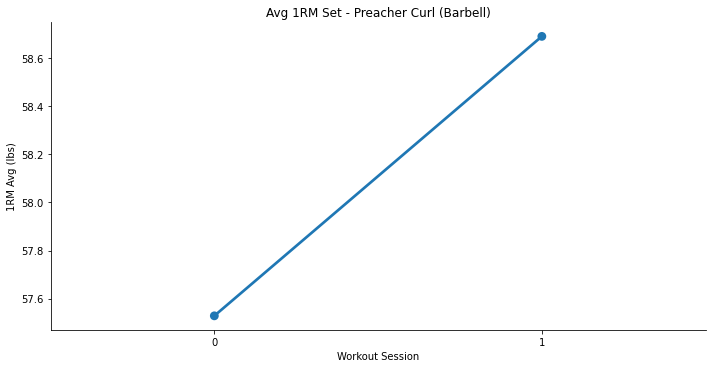

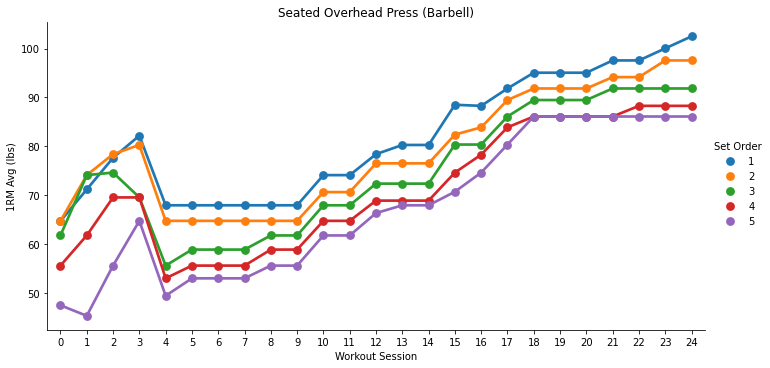

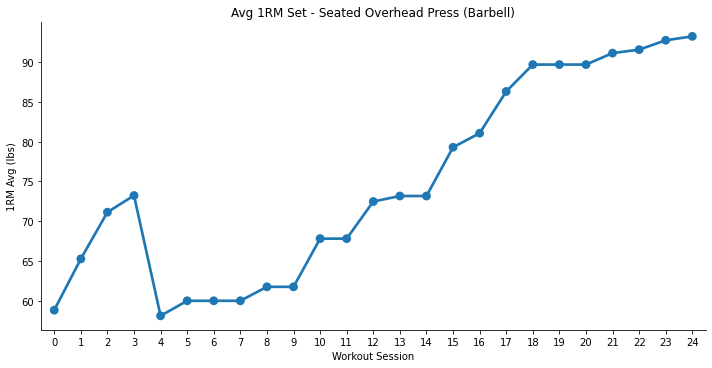

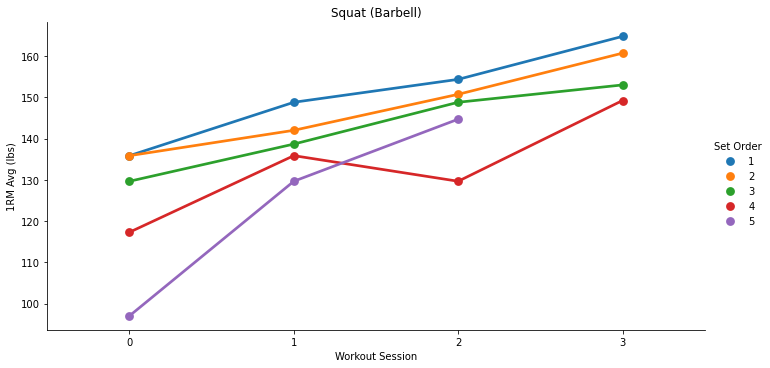

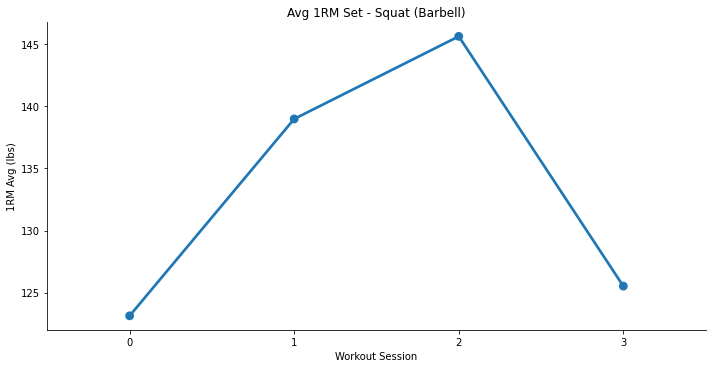

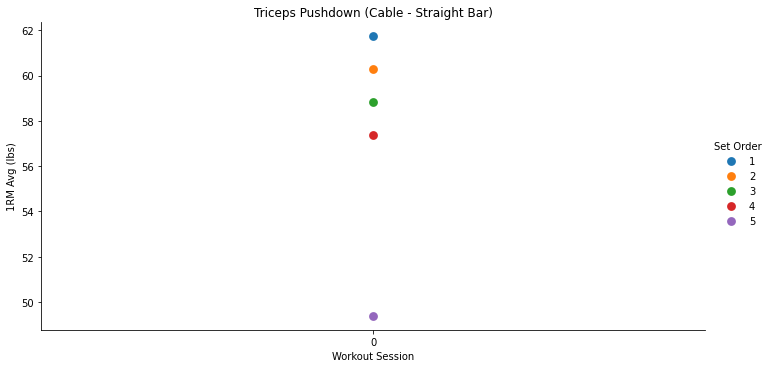

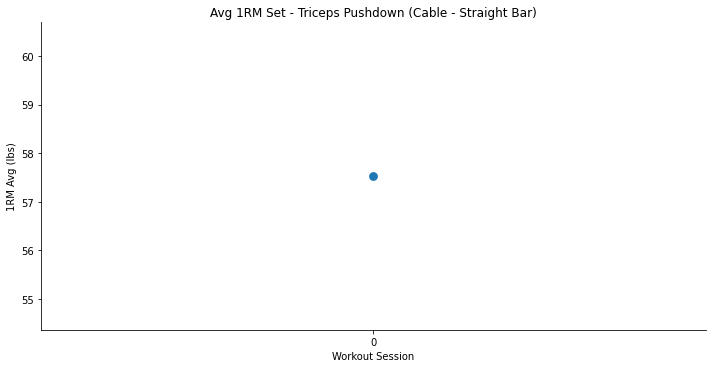

In [11]:
# create an Empty DataFrame object
mergedExercises = pd.DataFrame()

# get an array of unique Excercise Names
exercise_Names = np.unique(np.array(workout_history['Exercise Name']))

# loop through all the exercises in the dataframe
for exercise_Name in exercise_Names:
    # get all rows with that have the given exercise
    exercise = workout_history.loc[workout_history['Exercise Name'] == exercise_Name]

    dfs = dict(tuple(exercise.groupby('Set Order')))
    for x in dfs:
        # reset the index for each dataframe in the dictonary
        dfs[x] = dfs[x].reset_index()
        dfs[x] = dfs[x].reset_index()
        dfs[x] = dfs[x].rename(columns={'level_0': 'Workout Session'})
    
        # get 1RM's using different approximation methods. Then taking the avg of those methods
        dfs[x]["1RM Brzycki"] = ((dfs[x]["Weight"] * toKgs)  * (36 / (37 - dfs[x]["Reps"]))) * toPounds
        dfs[x]["1RM Epley"] = ((dfs[x]["Weight"] * toKgs)  * (1 + (0.0333 * dfs[x]["Reps"]))) * toPounds
        dfs[x]["1RM Lombardi"] = ((dfs[x]["Weight"] * toKgs)  * pow(dfs[x]["Reps"], 0.1)) * toPounds
        dfs[x]["1RM O’Conner"] = ((dfs[x]["Weight"] * toKgs)  * (1 + (0.025 * dfs[x]["Reps"]))) * toPounds
        dfs[x]["1RM Avg"] = (dfs[x]["1RM Brzycki"] + dfs[x]["1RM Epley"] + dfs[x]["1RM Lombardi"] + dfs[x]["1RM O’Conner"]) / 4
    
    # merge each sets dataframe into 1 dataframe for input in plotting
    mergedSets = pd.concat(dfs)
    # plot the exercise 1RM avgs per set
    sns.catplot(x='Workout Session', y='1RM Avg', hue='Set Order', data=mergedSets, kind='point', height=5, aspect=10/5)
    plt.title(exercise_Name)
    plt.ylabel('1RM Avg (lbs)')
    plt.show()
    
    # calculate avg of all sets in an exercise
    mergedAvgSet = mergedSets.groupby(['Workout Session'])['1RM Avg'].transform('sum') / len(dfs)
    # drop 'multi index' workout sessions
    mergedAvgSet = pd.DataFrame(mergedAvgSet).droplevel(0)
    # reset the index and rename
    mergedAvgSet = mergedAvgSet.reset_index().rename(columns={'index': 'Workout Session'})
    
    # merge each exercise dataframe into 1 dataframe for input in plotting
    mergedAvgSet['Exercise Name'] = exercise_Name
    mergedAvgSet['1RM Log'] = np.log(mergedAvgSet['1RM Avg']) - np.log(mergedAvgSet['1RM Avg'].shift(1))
    mergedAvgSet['1RM Diff'] = mergedAvgSet['1RM Avg'] - mergedAvgSet['1RM Avg'].shift(1)
    mergedExercises = pd.concat([mergedExercises, mergedAvgSet])
    
    # plot the avg exercise
    sns.catplot(x='Workout Session', y='1RM Avg', data=mergedAvgSet, kind='point', height=5, aspect=10/5)
    plt.title('Avg 1RM Set - ' + exercise_Name)
    plt.ylabel('1RM Avg (lbs)')
    plt.show()

    Workout Session     1RM Avg                            Exercise Name  \
0                 0  108.024484                    Bench Press (Barbell)   
1                 1  113.571253                    Bench Press (Barbell)   
2                 2  119.818533                    Bench Press (Barbell)   
3                 3  130.353993                    Bench Press (Barbell)   
4                 4  129.590133                    Bench Press (Barbell)   
..              ...         ...                                      ...   
0                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   
1                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   
2                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   
3                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   
4                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   

     1RM Log   1RM Diff  
0        NaN        NaN  
1   0.050073   5.546769  
2   0.053

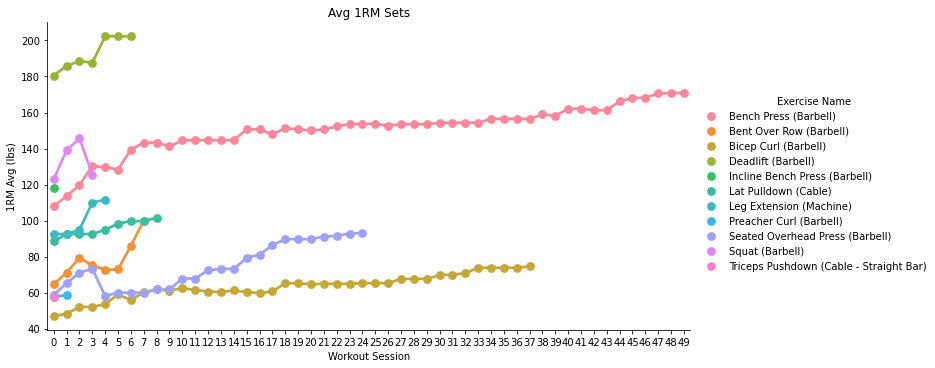

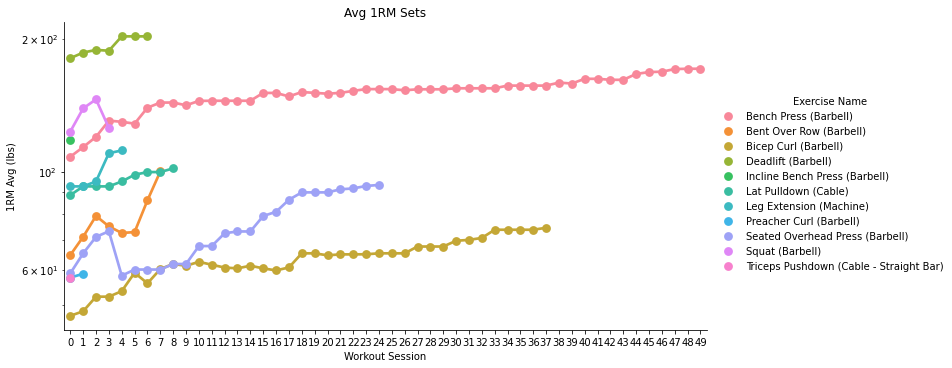

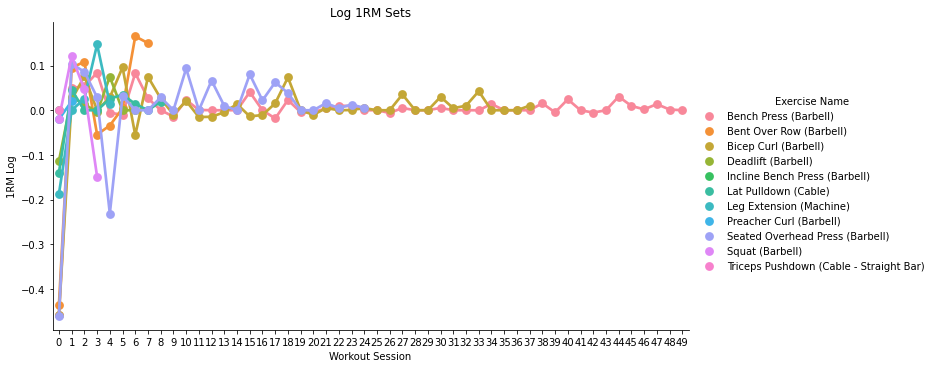

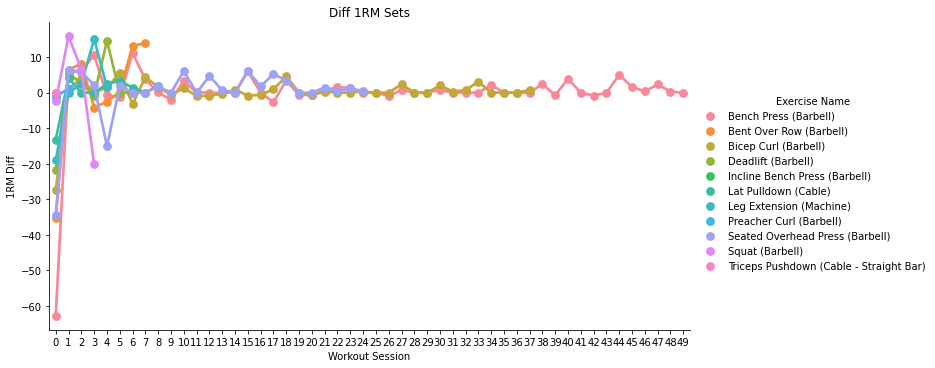

In [5]:
print(mergedExercises)

# plot the exercises 1RM avgs
sns.catplot(x='Workout Session', y='1RM Avg', hue='Exercise Name', data=mergedExercises, kind='point', height=5, aspect=10/5)
plt.title('Avg 1RM Sets')
plt.ylabel('1RM Avg (lbs)')
plt.show()

# plot the LOG exercises 1RM avgs
sns.catplot(x='Workout Session', y='1RM Avg', hue='Exercise Name', data=mergedExercises, kind='point', height=5, aspect=10/5)
plt.title('Avg 1RM Sets')
plt.ylabel('1RM Avg (lbs)')
plt.yscale('log')
plt.show()

# plot the LOG exercises 1RM avgs
sns.catplot(x='Workout Session', y='1RM Log', hue='Exercise Name', data=mergedExercises, kind='point', height=5, aspect=10/5)
plt.title('Log 1RM Sets')
#plt.yscale('log')
plt.show()

# plot the Diff exercises 1RM avgs
sns.catplot(x='Workout Session', y='1RM Diff', hue='Exercise Name', data=mergedExercises, kind='point', height=5, aspect=10/5)
plt.title('Diff 1RM Sets')
#plt.yscale('log')
plt.show()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y        
No. Observations: 150     Method:             REML     
No. Groups:       11      Scale:              36.9582  
Min. group size:  1       Log-Likelihood:     -513.1053
Max. group size:  50      Converged:          Yes      
Mean group size:  13.6                                 
-------------------------------------------------------
           Coef.   Std.Err.   z    P>|z| [0.025  0.975]
-------------------------------------------------------
Intercept   96.720   12.997  7.441 0.000 71.246 122.195
X            0.842    0.047 17.760 0.000  0.749   0.935
Group Var 1845.871  141.189                            



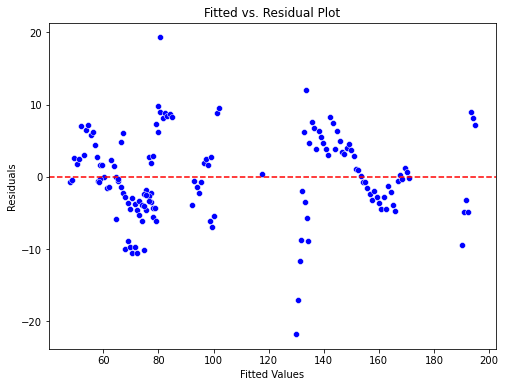

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Sample data
data = mergedExercises.drop(columns=['1RM Log', '1RM Diff']).drop_duplicates()
data = data.rename(columns={'Workout Session': 'X', '1RM Avg': 'y'})
data = data.reset_index(drop=True)

# Fit a linear mixed-effects model
model = smf.mixedlm("y ~ X", data, groups=data["Exercise Name"])
result = model.fit()
print(result.summary())

# Show Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=result.fittedvalues, y=result.resid, color='blue')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted vs. Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

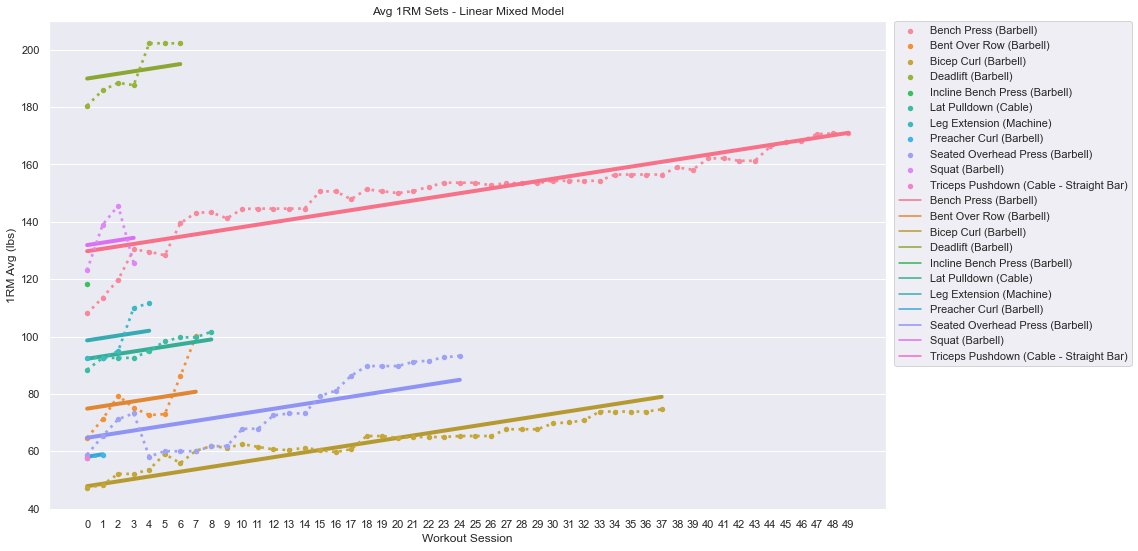

In [10]:
# get models predictions
data["Model"] = result.predict(data["X"])

for workout in result.random_effects:
    # add the random effects to each workout group
    mask = data['Exercise Name'].isin([workout])
    data.loc[mask, 'Model'] += result.random_effects[workout].values[0]
    
# plot the predictions
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(15,9)})
sns.pointplot(x='X', y='y', hue='Exercise Name', data=data, markers='.', linestyles=':', ax=ax)
sns.lineplot(x='X', y='Model', hue='Exercise Name', data=data, linewidth = 4, ax=ax)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title('Avg 1RM Sets - Linear Mixed Model')
plt.xlabel('Workout Session')
plt.ylabel('1RM Avg (lbs)')
plt.show()
sns.reset_orig()

C:\Users\Kevin\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


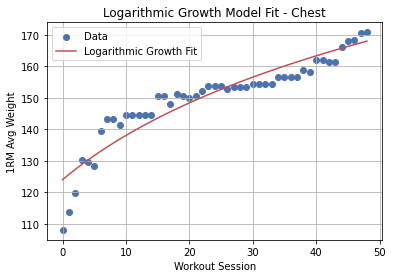

Logarithmic Growth Model Accuracy (MSE): 77.13%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data
df = mergedExercises[mergedExercises['Exercise Name'].str.match("Bench Press \(Barbell\)")].head(49)
time = df["Workout Session"]
weight = df["1RM Avg"]

# Logarithmic growth model
def logarithmic_growth(x, a, b):
    return a * np.log(x + b)

# Fit the logarithmic growth model to the data
params, covariance = curve_fit(logarithmic_growth, time, weight)

# Parameters a and b represent the fit parameters
a, b = params

# Predict values using the fitted model
weight_pred = logarithmic_growth(time, a, b)

# Plot the data and the fitted curve
plt.scatter(time, weight, label='Data', color='b')
plt.plot(time, weight_pred, label='Logarithmic Growth Fit', color='r')
plt.xlabel('Workout Session')
plt.ylabel('1RM Avg Weight')
plt.title('Logarithmic Growth Model Fit - Chest')
plt.legend()
plt.grid(True)
plt.show()

# Calculate accuracy (in terms of MSE)
mse = ((weight - weight_pred) ** 2).mean()
accuracy = 100 - mse  # Assuming higher MSE implies lower accuracy

print(f'Logarithmic Growth Model Accuracy (MSE): {accuracy:.2f}%')


In [13]:
#mergedExercises.groupby(['Exercise Name'])['1RM Avg']
df1 = mergedExercises[mergedExercises['Exercise Name'].str.match("Bench Press \(Barbell\)")].drop(columns=['Workout Session', 'Exercise Name'])
df2 = mergedExercises[mergedExercises['Exercise Name'].str.match("Bicep Curl \(Barbell\)")].drop(columns=['Workout Session', 'Exercise Name'])
# .diff().corr()
#df1.diff()
df1.diff().corrwith(df2.diff(), axis = 0)

1RM Avg     0.007904
1RM Log     0.012743
1RM Diff    0.015945
dtype: float64

In [14]:
print(df1.diff())
print(df2.diff())

       1RM Avg   1RM Log   1RM Diff
0          NaN       NaN        NaN
1     5.546769       NaN        NaN
2     6.247280  0.003475   0.700512
3    10.535459  0.030727   4.288179
4    -0.763859 -0.090153 -11.299318
..         ...       ...        ...
245   1.621424 -0.020912  -3.392455
246   0.335656 -0.007706  -1.285768
247   2.324610  0.011725   1.988954
248   0.280988 -0.012076  -2.043622
249   0.000000 -0.001646  -0.280988

[250 rows x 3 columns]
      1RM Avg   1RM Log  1RM Diff
0         NaN       NaN       NaN
1    1.138891       NaN       NaN
2    3.809662  0.052078  2.670771
3    0.000000 -0.075951 -3.809662
4    1.516449  0.028697  1.516449
..        ...       ...       ...
185  3.086254  0.032558  2.372251
186  0.000000 -0.042702 -3.086254
187  0.000000  0.000000  0.000000
188  0.000000  0.000000  0.000000
189  0.762171  0.010271  0.762171

[190 rows x 3 columns]
